# ЛР №5

Вариант 5
Студент: Геворкян Д.Ф.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

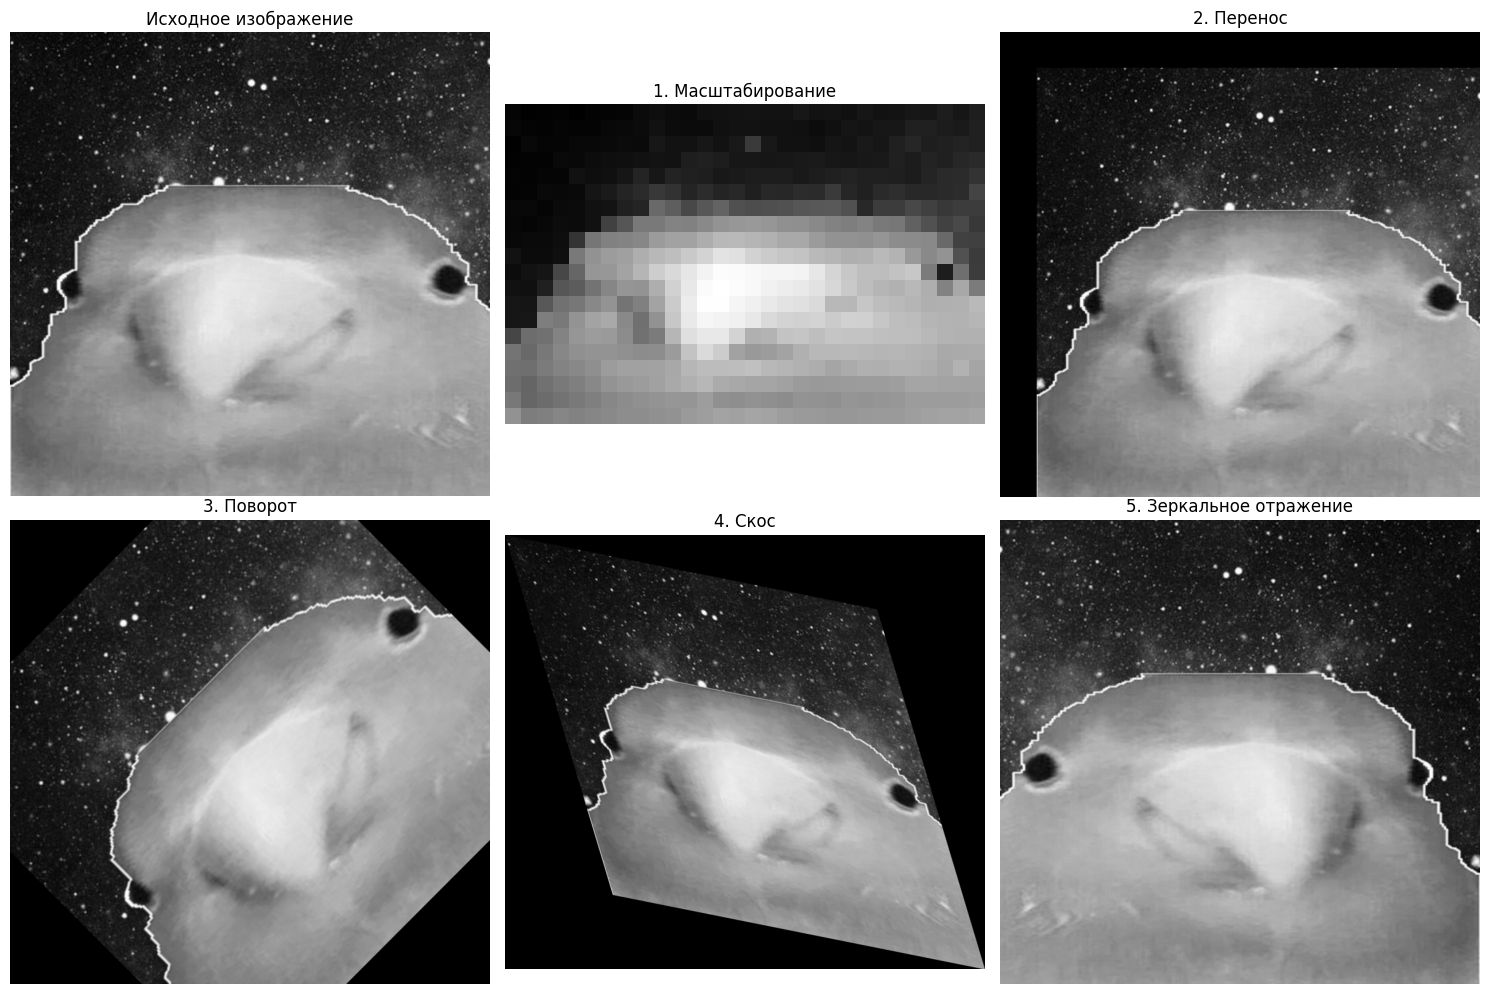

In [10]:
def affine_transformations(image):
    h, w = image.shape[:2]

    scaled = cv2.resize(image, (30, 20), interpolation=cv2.INTER_AREA)  # ширина = 300, высота = 200

    M_translate = np.float32([[1, 0, 50], [0, 1, 50]])
    translated = cv2.warpAffine(image, M_translate, (w + 50, h + 50))

    center = (w // 2, h // 2)
    M_rotate = cv2.getRotationMatrix2D(center, 45, 1.0)
    rotated = cv2.warpAffine(image, M_rotate, (w, h))

    shear_x = 0.3
    shear_y = 0.2
    M_shear = np.float32([[1, shear_x, 0],
                          [shear_y, 1, 0]])
    sheared = cv2.warpAffine(image, M_shear, (int(w + shear_x * h), int(h + shear_y * w)))

    mirrored = cv2.flip(image, 1)

    return scaled, translated, rotated, sheared, mirrored

def main():
    image = cv2.imread('pepuk.jpg', cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Ошибка загрузки изображения")
        return

    scaled, translated, rotated, sheared, mirrored = affine_transformations(image)

    titles = [
        'Исходное изображение',
        '1. Масштабирование',
        '2. Перенос',
        '3. Поворот',
        '4. Скос',
        '5. Зеркальное отражение'
    ]
    images = [image, scaled, translated, rotated, sheared, mirrored]

    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

main()

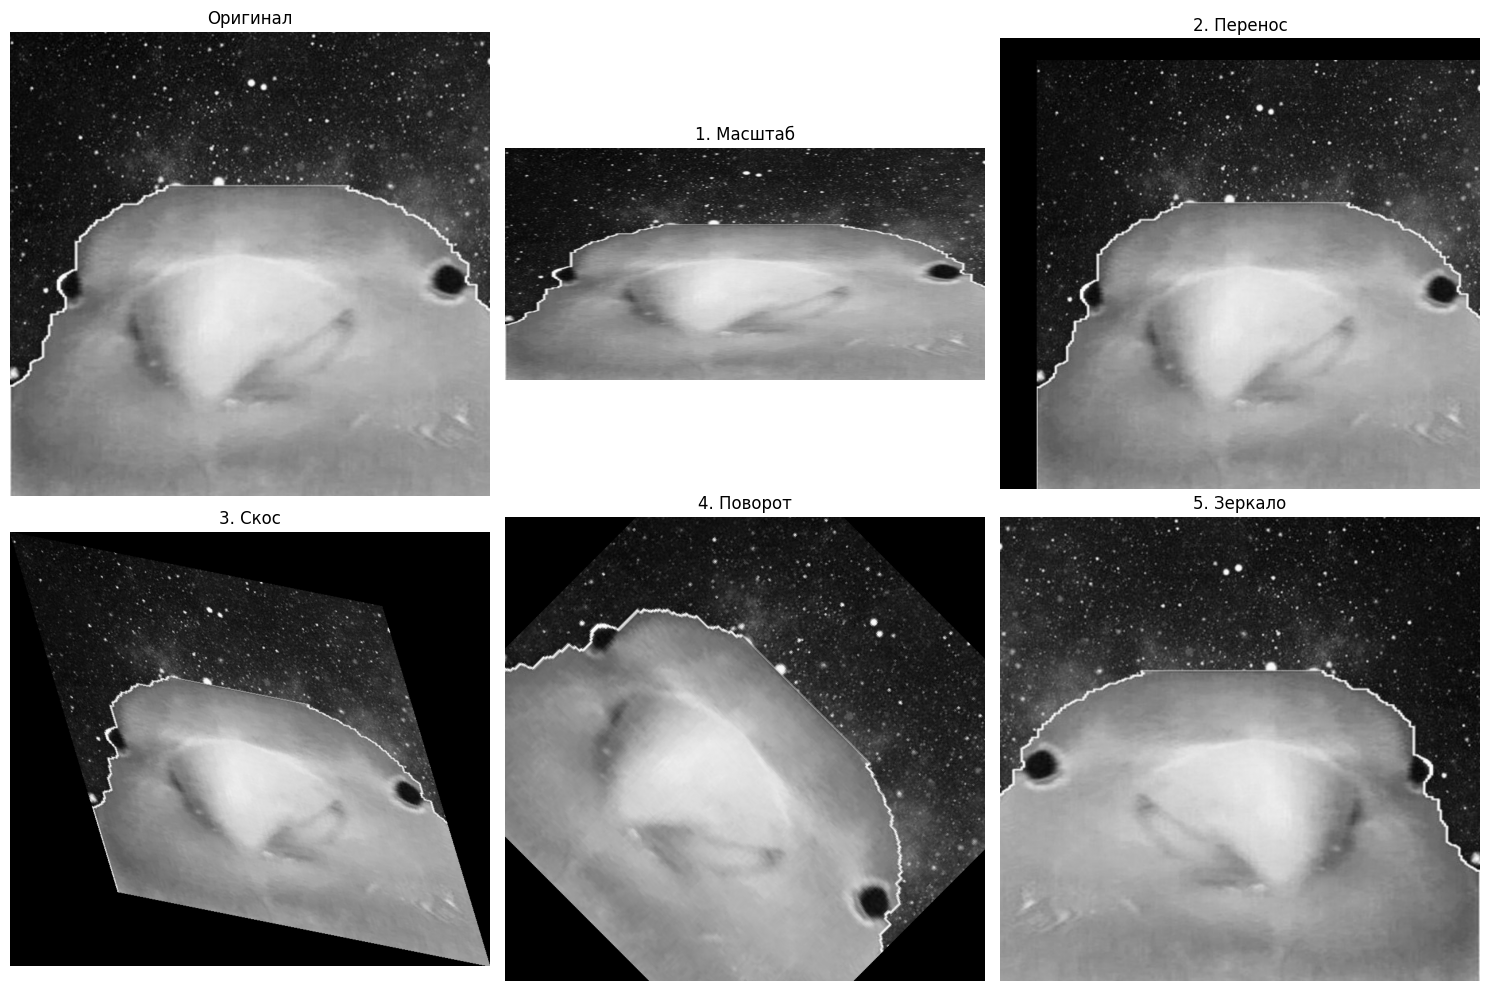

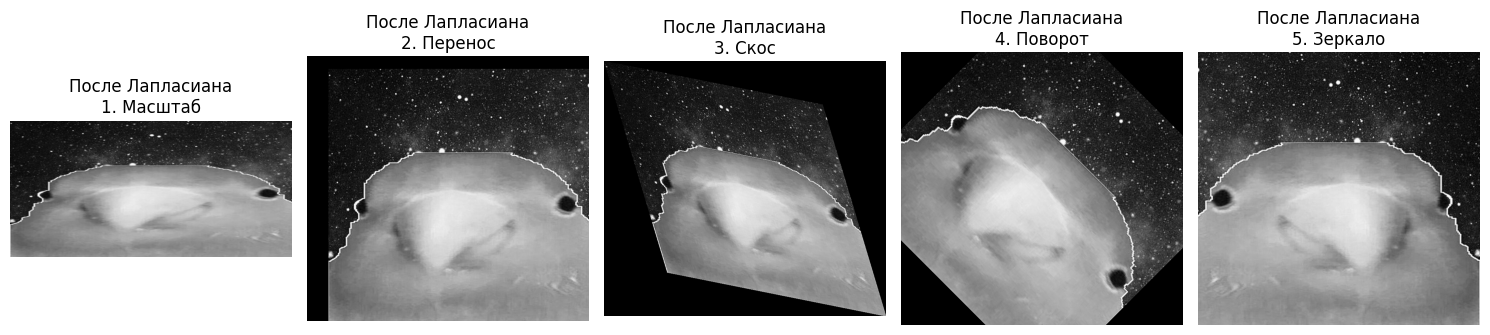

In [14]:
def apply_affine_transform(image, matrix, output_size):
    h_out, w_out = output_size
    result = np.zeros((h_out, w_out), dtype=np.uint8)
    M_inv = np.linalg.inv(matrix)

    for y_out in range(h_out):
        for x_out in range(w_out):
            src_coords = M_inv @ np.array([x_out, y_out, 1])
            x_src, y_src = src_coords[:2]

            x0, y0 = int(x_src), int(y_src)

            if 0 <= x0 < image.shape[1] and 0 <= y0 < image.shape[0]:
                result[y_out, x_out] = image[y0, x0]

    return result

def scale(image, sx, sy):
    h, w = image.shape
    M = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])
    return apply_affine_transform(image, M, (int(h * sy), int(w * sx)))

def translate(image, tx, ty):
    h, w = image.shape
    M = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])
    return apply_affine_transform(image, M, (h + ty, w + tx))

def shear(image, shx, shy):
    h, w = image.shape
    M = np.array([
        [1, shx, 0],
        [shy, 1, 0],
        [0, 0, 1]
    ])
    new_w = int(w + abs(shx) * h)
    new_h = int(h + abs(shy) * w)
    return apply_affine_transform(image, M, (new_h, new_w))

def rotate(image, angle_deg):
    h, w = image.shape
    angle_rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    cx, cy = w / 2, h / 2

    M = np.array([
        [cos_a, -sin_a, (1 - cos_a) * cx + sin_a * cy],
        [sin_a,  cos_a, (1 - cos_a) * cy - sin_a * cx],
        [0, 0, 1]
    ])
    return apply_affine_transform(image, M, (h, w))

def mirror(image):
    h, w = image.shape
    M = np.array([
        [-1, 0, w - 1],
        [0, 1, 0],
        [0, 0, 1]
    ])
    return apply_affine_transform(image, M, (h, w))

def postprocess_laplacian(image):
    laplacian_kernel = np.array([[1, 1, 1],
                                  [1, -8, 1],
                                  [1, 1, 1]], dtype=np.float32) / 10
    laplacian = cv2.filter2D(image.astype(np.float32), -1, laplacian_kernel)
    sharpened = image.astype(np.float32) - laplacian
    return np.clip(sharpened, 0, 255).astype(np.uint8)

def main():
    image = cv2.imread('pepuk.jpg')

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    scaled = scale(gray, 6, 3)
    translated = translate(gray, 50, 30)
    sheared = shear(gray, 0.3, 0.2)
    rotated = rotate(gray, 45)
    mirrored = mirror(gray)

    results = [gray, scaled, translated, sheared, rotated, mirrored]
    titles = [
        'Оригинал',
        '1. Масштаб',
        '2. Перенос',
        '3. Скос',
        '4. Поворот',
        '5. Зеркало'
    ]

    plt.figure(figsize=(15, 10))
    for i in range(len(results)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(results[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Постобработка
    plt.figure(figsize=(15, 6))
    for i in range(1, len(results)):  # исключаем оригинал
        post = postprocess_laplacian(results[i])
        plt.subplot(1, 5, i)
        plt.imshow(post, cmap='gray')
        plt.title(f'После Лапласиана\n{titles[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

main()

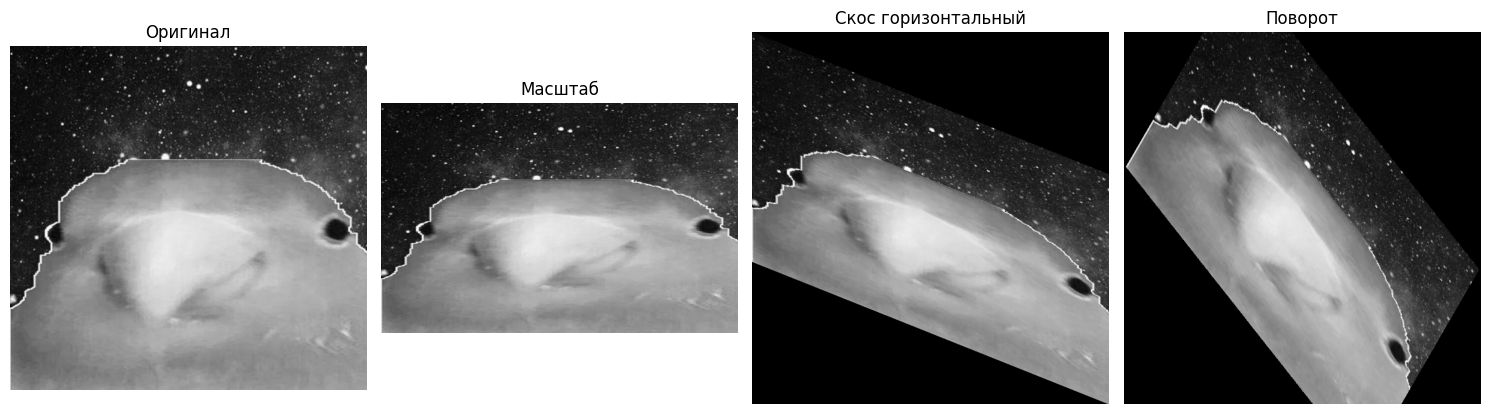

In [8]:
def apply_affine_transform(image, matrix, output_size):
    h_out, w_out = output_size
    result = np.zeros((h_out, w_out), dtype=np.uint8)
    M_inv = np.linalg.inv(matrix)

    for y_out in range(h_out):
        for x_out in range(w_out):
            src_coords = M_inv @ np.array([x_out, y_out, 1])
            x_src, y_src = src_coords[:2]
            x0, y0 = int(x_src), int(y_src)

            if 0 <= x0 < image.shape[1] and 0 <= y0 < image.shape[0]:
                result[y_out, x_out] = image[y0, x0]

    return result

def scale(image, cx, cy):
    h, w = image.shape
    M = np.array([
        [cx, 0, 0],
        [0, cy, 0],
        [0, 0, 1]
    ])
    return apply_affine_transform(image, M, (int(h * cy), int(w * cx)))

def shear_horizontal(image, sh):
    h, w = image.shape
    M = np.array([
        [1, 0, 0],
        [sh, 1, 0],
        [0, 0, 1]
    ])
    new_h = int(h + abs(sh) * w)
    return apply_affine_transform(image, M, (new_h, w))

def rotate(image, angle_deg):
    h, w = image.shape
    angle_rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    cx, cy = w / 2, h / 2

    M = np.array([
        [cos_a, -sin_a, (1 - cos_a) * cx + sin_a * cy],
        [sin_a,  cos_a, (1 - cos_a) * cy - sin_a * cx],
        [0, 0, 1]
    ])
    return apply_affine_transform(image, M, (h, w))

def main():
    image = cv2.imread('pepuk.jpg')
    if image is None:
        print("Ошибка загрузки изображения")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    scaled = scale(gray, 1.2, 0.8)
    sheared = shear_horizontal(scaled, 0.4)
    rotated = rotate(sheared, 30)

    plt.figure(figsize=(15, 6))
    titles = ['Оригинал', 'Масштаб', 'Скос горизонтальный', 'Поворот']
    images = [gray, scaled, sheared, rotated]

    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    (plt.show())


main()
